In [257]:
import numpy as np 
import os, sys
import time
from text_flappy_bird_gym.envs.text_flappy_bird_env_simple import TextFlappyBirdEnvSimple
from collections import defaultdict
import agent
import tqdm
import matplotlib.pyplot as plt

In [258]:
env = TextFlappyBirdEnvSimple()

# Monte Carlo

In [259]:

def simulation(env, Q,plot=True):
    """ generates an episode with an optimal policy """
    nA = env.action_space.n
    episode = []
    state,infos = env.reset()
    while len(episode)<10000:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], 0,nA)) \
                                    if state in Q else env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done,f, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if plot:
            os.system("clear")
            sys.stdout.write(env.render())
            print(action)
            time.sleep(0.5) 
        if done:
            break
    return episode, env._get_info()['score']



def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state,infos = env.reset()
    while len(episode)<10000:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        # take a step in the environement 
        next_state, reward, done,f, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode, env._get_info()['score']

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA)*epsilon/nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1-epsilon+(epsilon/nA)

    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]]
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q



def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.999, eps_min=0.005):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    scores = []
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode, sc = generate_episode_from_Q(env, Q, epsilon, nA)
        scores.append(sc)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q, scores

# Sarsa

In [285]:


def simulation_sarsa(env, agent,plot=False,eps_min=0.005,update=True):
    """ generates an episode with an optimal policy """
    nA = env.action_space.n
    episode = []
    state,infos = env.reset()
    reward =1
    done=False
    while len(episode)<10000:
        action = agent.agent_step(1-int(done),state,eps_min=eps_min,update=update)
        if done:
            break
        # take a step in the environement 
        next_state, reward, done,f, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if plot:
            sys.stdout.write(env.render())
            time.sleep(0.5) 
    return episode,env._get_info()['score']


def get_probs_sarsa(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA)*epsilon/nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1-epsilon+(epsilon/nA)

    return policy_s

class ExpectedSarsaAgent(agent.BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.height = agent_init_info["height"]
        self.width = agent_init_info["width"]
        self.num_states = self.width*self.height
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.

    def state1D(self,pos):
        return pos[1]+pos[0]*self.width+10
        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[self.state1D(state), :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state,eps_decay=0.9999,eps_min=0.005,update=True):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        self.epsilon=max(self.epsilon*eps_decay,eps_min)
        current_q = self.q[self.state1D(state),:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
    
        expected_q = np.dot(self.q[self.state1D(state), :], get_probs_sarsa(self.q[self.state1D(state), :], self.epsilon, self.num_actions))
        if update:
            self.q[self.prev_state, self.prev_action] += self.step_size * (reward + self.discount * expected_q - self.q[self.prev_state, self.prev_action])
        
        self.prev_state = self.state1D(state)
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
    
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward - self.q[self.prev_state, self.prev_action])
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)


# Test

Episode 5000/5000.

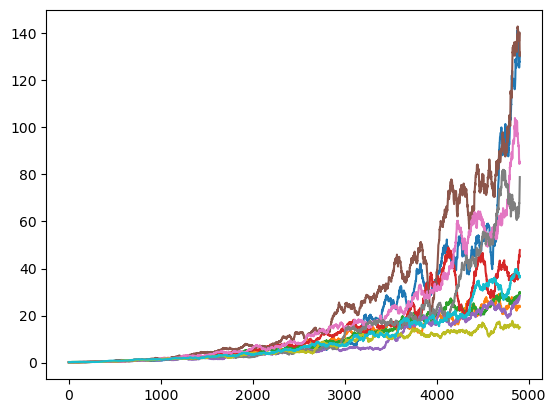

In [261]:
best_score_MC= 0
best_policy_MC = 0
best_Q_MC = 0
best_score_list_MC = []
for i in range(10):
    policy_MC ,Q_MC, scores = mc_control(env,5000,0.01)
    plt.plot(np.convolve(np.array(scores),np.ones(100),mode='valid')/100,label='Monte Carlo')
    if np.mean(scores[-200:])>best_score_MC:
        best_score_MC = np.mean(scores[-200:])
        best_policy_MC = policy_MC
        best_Q_MC = Q_MC
        best_score_list_MC = scores


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [07:50<00:00, 10.64it/s] 


Text(0, 0.5, 'Score')

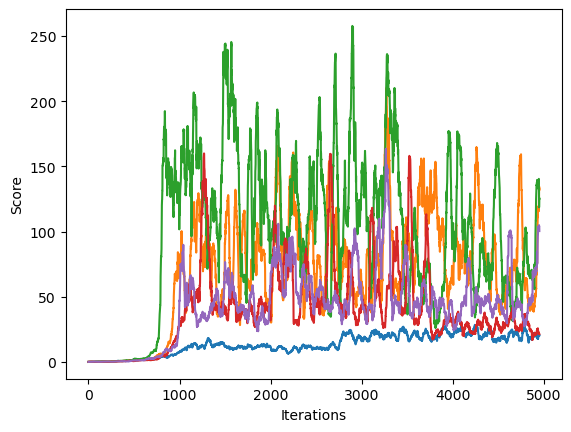

In [287]:
best_score_SARSA = 0
best_score_list = []
for i in range(5):
    score_list = []
    obs = env.reset()[0]

    agent_info = {"num_actions": 2, "height": 15,"width":20, "epsilon": 0.9, "step_size": 0.3, "discount": 0.9, "seed": 0}
    sarsa_agent = ExpectedSarsaAgent()
    sarsa_agent.agent_init(agent_info)
    action = sarsa_agent.agent_start(obs)
    for i in tqdm.tqdm(range(5000)):
        ep,score = simulation_sarsa(env,sarsa_agent)
        score_list.append(score)
    if np.mean(score_list[-200:])>best_score_SARSA:
        best_score_SARSA = np.mean(score_list[-200:])
        best_agent_sarsa = sarsa_agent
        best_score_list=score_list
    plt.plot(np.convolve(np.array(score_list),np.ones(50),mode='valid')/50,label='Monte Carlo')
plt.xlabel('Iterations')
plt.ylabel('Score')


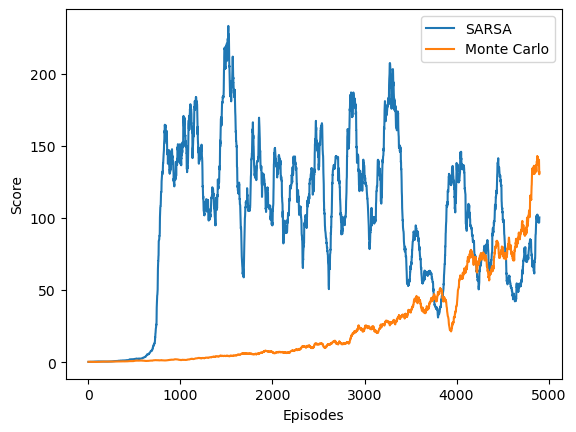

In [288]:
plt.plot(np.convolve(np.array(best_score_list),np.ones(100),mode='valid')/100, label = 'SARSA')
plt.plot(np.convolve(np.array(best_score_list_MC),np.ones(100),mode='valid')/100,label='Monte Carlo')
plt.xlabel('Episodes')
plt.ylabel('Score')
plt.legend()

In [289]:
sarsa_agent.epsilon=0
mean_score_sarsa = []
mean_score_MC = []
for i in tqdm.tqdm(range(100)):
    env.reset()
    _,score_sarsa = simulation_sarsa(env,best_agent_sarsa,eps_min=0,update=False)
    mean_score_sarsa.append(score_sarsa)
    env.reset()
    _, score_MC = simulation(env,best_Q_MC,plot=False)
    mean_score_MC.append(score_MC)
print(np.mean(mean_score_sarsa))
print(np.mean(mean_score_MC))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:55<00:00,  3.55s/it]

799.45
999.0


# Influence of level configuration

In [290]:
for height in [7,10,15]:
    for width in [10,15,20]:
        for delta in [3,4,6]:
            if height>delta+2:
                env2 = TextFlappyBirdEnvSimple(height,width,delta)
                sarsa_agent.epsilon=0
                mean_score_sarsa = []
                mean_score_MC = []
                for i in range(30):
                    env2.reset()
                    _,score_sarsa = simulation_sarsa(env2,best_agent_sarsa,eps_min=0,update=False)
                    mean_score_sarsa.append(score_sarsa)
                    env2.reset()
                    _, score_MC = simulation(env2,best_Q_MC,plot=False)
                    mean_score_MC.append(score_MC)
                print(height,width,delta,np.mean(mean_score_MC),np.mean(mean_score_sarsa))

7 10 3 2.033333333333333 1.1666666666666667
7 10 4 1999.0 1999.0
7 15 3 2.6666666666666665 0.3
7 15 4 1249.0 1249.0
7 20 3 1.6666666666666667 1.2333333333333334
7 20 4 999.0 999.0
10 10 3 1.0333333333333334 0.5333333333333333
10 10 4 1999.0 13.733333333333333
10 10 6 1999.0 1999.0
10 15 3 1.6333333333333333 0.6
10 15 4 1249.0 1249.0
10 15 6 1249.0 1249.0
10 20 3 2.4 0.9
10 20 4 999.0 999.0
10 20 6 999.0 999.0
15 10 3 1.4 1.2333333333333334
15 10 4 14.166666666666666 5.566666666666666
15 10 6 55.0 9.166666666666666
15 15 3 1.6666666666666667 1.1666666666666667
15 15 4 145.73333333333332 83.93333333333334
15 15 6 1249.0 1249.0
15 20 3 1.9 1.0
15 20 4 999.0 803.6
15 20 6 999.0 999.0
